# Setup

Import TensorFlow and other necessary libraries:

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL 
import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Download and explore the datase

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

`flower_photo/`

      daisy/

      dandelion/

      roses/

      sunflowers/
  
      tulips/

In [20]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

After downloading, we should now have a copy of the dataset available. There are 3,670 total images:

In [21]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

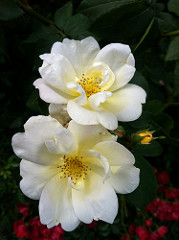

In [22]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

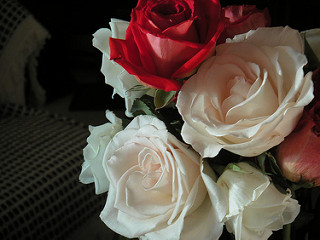

In [23]:
PIL.Image.open(str(roses[1]))

Add some tulips:

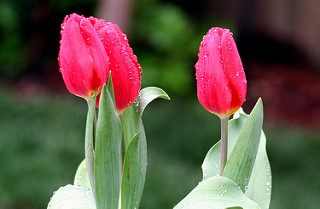

In [24]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

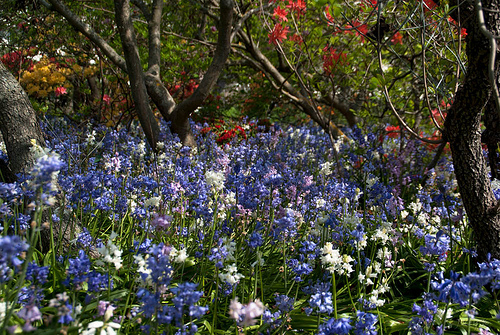

In [25]:
PIL.Image.open(str(tulips[1]))

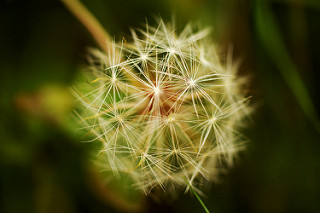

In [26]:
# print images from dandlion
dandelion = list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(dandelion[0]))

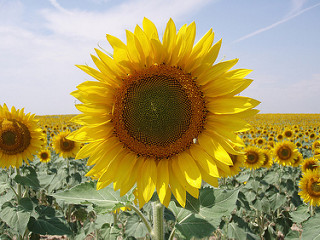

In [27]:
# print images from sunflowers
sunflower = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflower[1]))

# Load data using a Keras utility

## Create a dataset

Define some parameters for the loader:

In [28]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [29]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [31]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualize the data

Here are the first nine images from the training dataset:

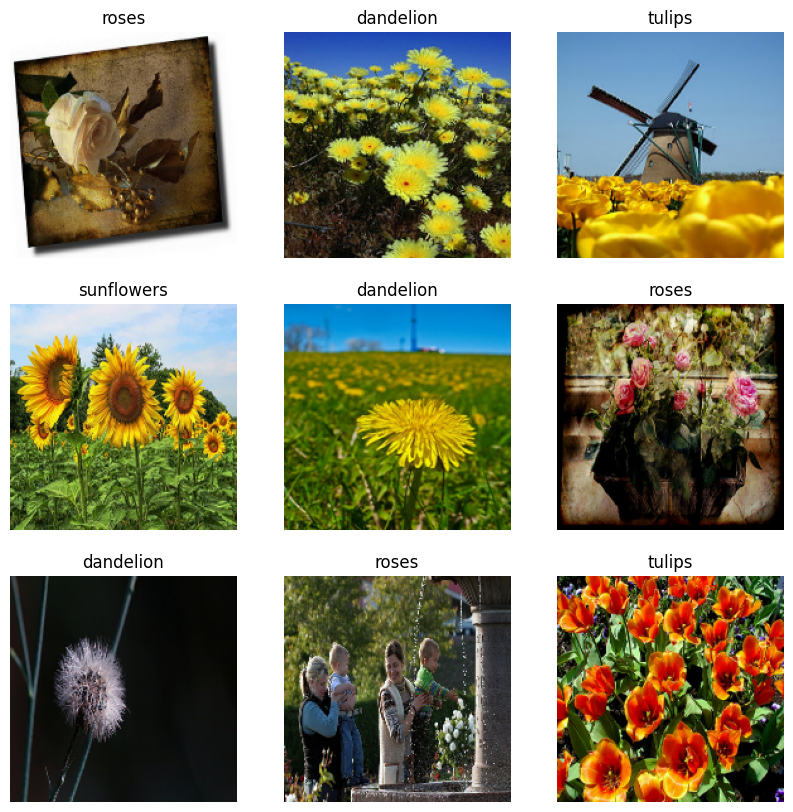

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

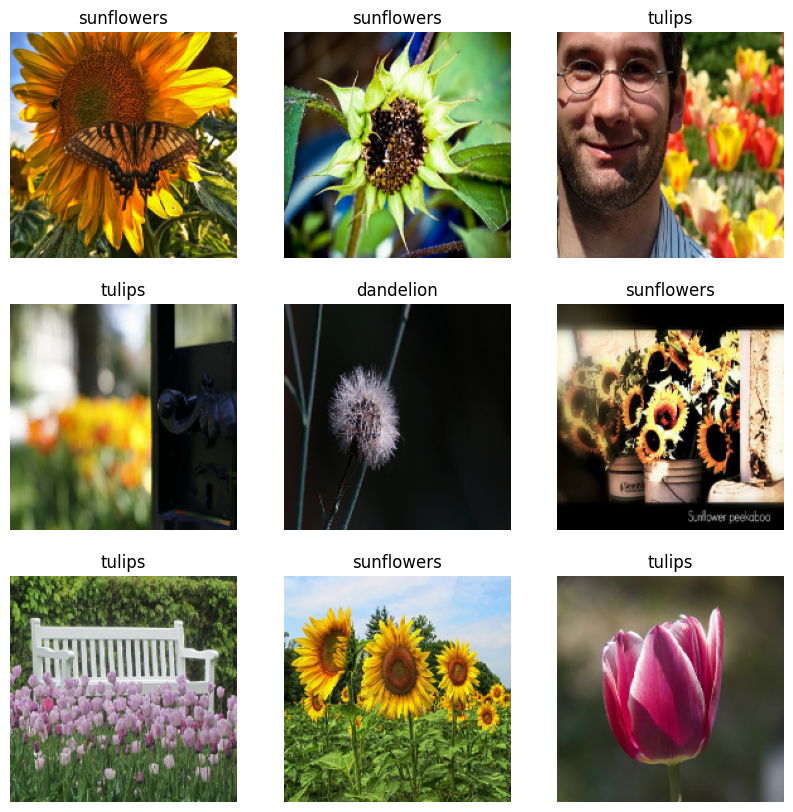

In [33]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

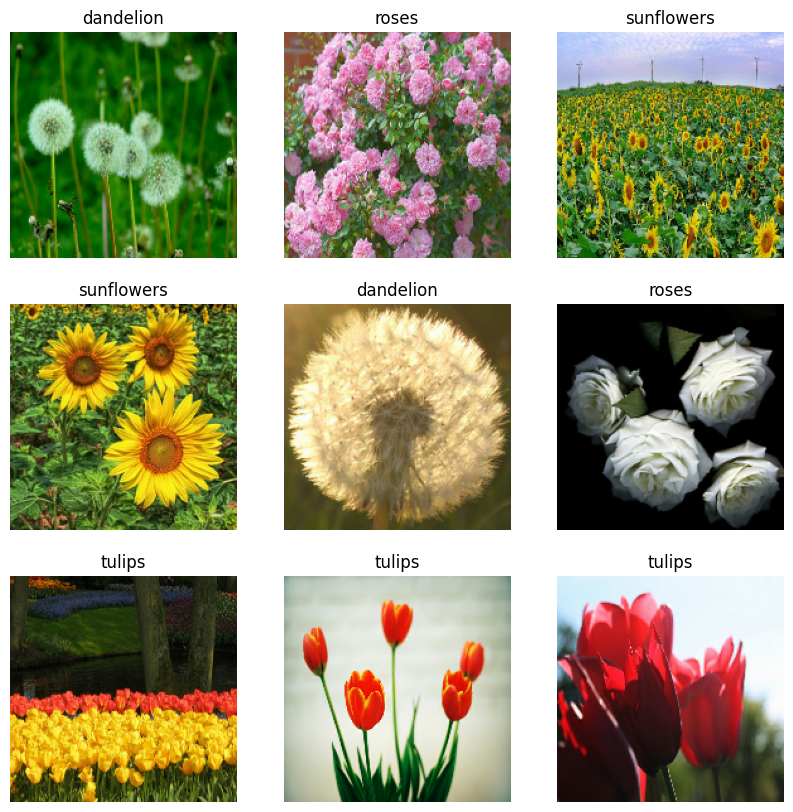

In [34]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

Cell In[103], line 1
    for image_batch, labels_batch in
                                     ^
SyntaxError: invalid syntax

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualize the data

Here are the first nine images from the training dataset:

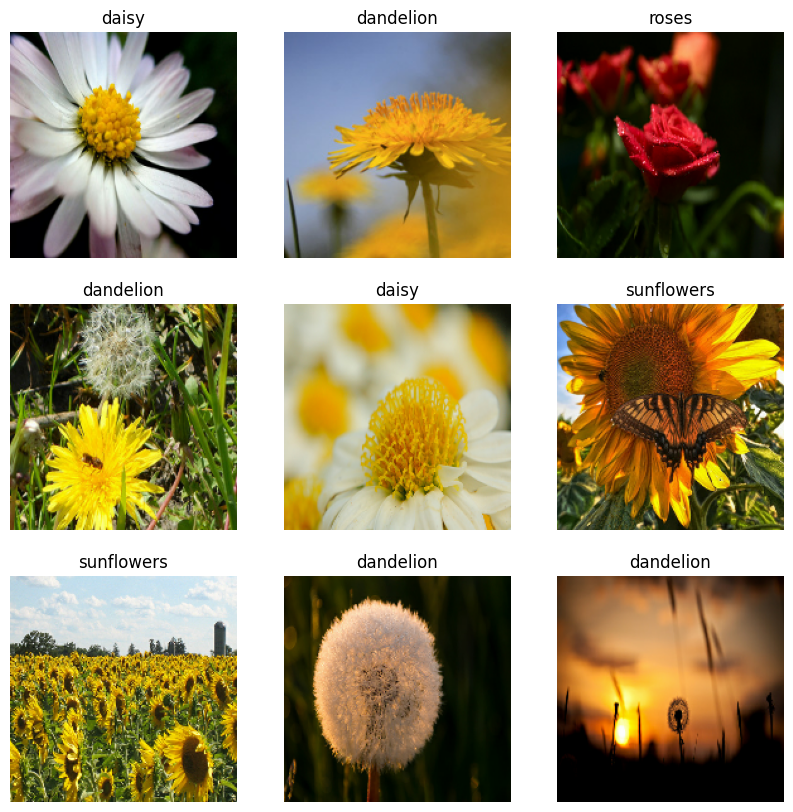

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Karas Model.fit method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [37]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)` , these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray.`

# Configure the dataset for performance

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE) # cache() keeps images in memory after they are loaded off disk during the first epoch
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE) # prefetch() overlaps data preprocessing and model execution while training

# Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using `tf.keras.layers.Rescaling:`

In [39]:
normalization_layer = layers.Rescaling(1./255) # rescale pixel values from [0, 255] to 

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map:`

In [48]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, We can include the layer inside our model definition, which can simply deployment.  We can use the second approach here.

Note: We previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If we want to include the resizing logic in our model as well , we can use the `tf.keras.layers.Resizing` layer

# A basic Keras model

## Create the model

The Keras Sequential model consists of three convolution blocks (`tf.keras.layers.Conv2D)` with a max pooling layer `(tf.keras.layers.MaxPooling2D)` in each of them. There's a fully-connected layer `(f.keras.layers.Dense)` with 128 units on top of it that is activated by a ReLU activation function `(relu)`. This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [51]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding = 'same', activation='relu'),
    layers.MaxPooling2D(), 
    layers.Conv2D(32, 3, padding = 'same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Compile the model

For this tutorial, choose `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the metrics argument `to Model.compile`.

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary

View all the layers of the network using the Keras `Mode.summary method`:

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train the model 

Train the model for 10 epochs with with the Keras `Model.fit method:

In [55]:
%%time
epochs = 10
history = model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 88s 928ms/step - loss: 1.3665 - accuracy: 0.4203 - val_loss: 1.0681 - val_accuracy: 0.5722
Epoch 2/10
92/92 [==============================] - 80s 867ms/step - loss: 0.9790 - accuracy: 0.6199 - val_loss: 1.0067 - val_accuracy: 0.5940
Epoch 3/10
92/92 [==============================] - 80s 868ms/step - loss: 0.8139 - accuracy: 0.6982 - val_loss: 0.8906 - val_accuracy: 0.6499
Epoch 4/10
92/92 [==============================] - 80s 867ms/step - loss: 0.6017 - accuracy: 0.7813 - val_loss: 1.0171 - val_accuracy: 0.6226
Epoch 5/10
92/92 [==============================] - 82s 891ms/step - loss: 0.4275 - accuracy: 0.8501 - val_loss: 1.0883 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 80s 870ms/step - loss: 0.2728 - accuracy: 0.9111 - val_loss: 1.1811 - val_accuracy: 0.6499
Epoch 7/10
92/92 [==============================] - 80s 870ms/step - loss: 0.1389 - accuracy: 0.9557 - val_loss: 1.4236 - val_accuracy: 0.6458

In [63]:
# print the final training and validation accuracy + loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# print the final training and validation accuracy + loss 
print(f"----{'-'*10}----")
print("Training accuracy: {:.2f}".format(acc[-1]))
print("Validation accuracy: {:.2f}".format(val_acc[-1]))
print(f"----{'-'*10}----")
print("Training loss: {:.2f}".format(loss[-1]))
print("Validation loss: {:.2f}".format(val_loss[-1]))

------------------
Training accuracy: 1.00
Validation accuracy: 0.64
------------------
Training loss: 0.02
Validation loss: 1.82


# Visualize training results


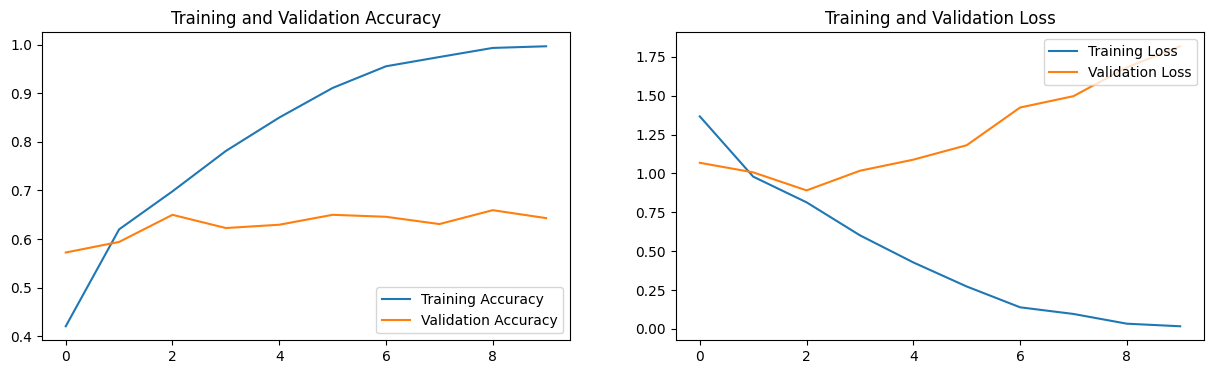

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data augmentation

In [68]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                           input_shape=(img_height,
                                        img_width,
                                        3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

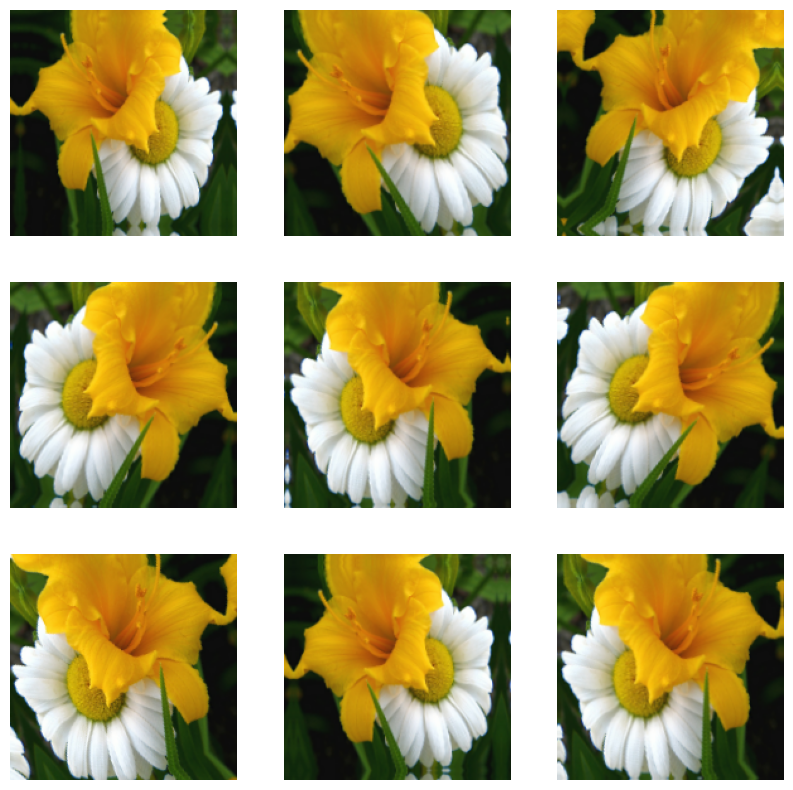

In [71]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[5].numpy().astype("uint8"))
        plt.axis("off")

We will add data augmentation to our model before training in the next step.

# Dropout

Another technique to reduce overfitting is to reduce dropout regularization to the network.


In [73]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1.,255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

# Compile and train the mode

In [75]:
model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

In [76]:
model.summa

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [77]:
%%time
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs,
    verbose=0
)

CPU times: total: 49min 55s
Wall time: 17min 47s


# Visualize training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [1]:
# print the final training and validation accuracy + loss 
print(f"----{'-'*10}----")
print("Training accuracy: {:.2f}".format(acc[-1]))
print("Validation accuracy: {:.2f}".format(val_acc[-1]))
print(f"----{'-'*10}----")
print("Training loss: {:.2f}".format(loss[-1]))
print("Validation loss: {:.2f}".format(val_loss[-1]))

------------------


NameError: name 'acc' is not defined

# Predict on new data

We use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [2]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .formats(class_names[np.argmax(score)], 100 + np.max(score))
      )

NameError: name 'tf' is not defined

# Use TensorFlow Lite

## Convert the Keras Sequential model to a TensorFlow Lite model

In [5]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

NameError: name 'model' is not defined

# **`Assignment:`**

1. Please use any image pre trained model on this network and increase the accuracy on validation data.